In [1]:
# Imports 
import pandas as pd
from ast import literal_eval
import numpy as np
import os 
import sys
sys.path.append('/disk1/ariane/vscode/enzyme-tk')
from enzymetk.sequence_search_blast import BLAST
from enzymetk.similarity_foldseek_step import FoldSeek
from enzymetk.similarity_reaction_step import ReactionDist
from enzymetk.save_step import Save
import pandas as pd
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'

## First build the training sets
from sciutil import SciUtil
from rdkit import Chem, DataStructs
from rdkit.Chem import rdChemReactions
from sklearn.metrics.pairwise import cosine_similarity


def clean_plt(ax):
    ax.tick_params(direction='out', length=2, width=1.0)
    ax.spines['bottom'].set_linewidth(1.0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(labelsize=10.0)
    ax.tick_params(axis='x', which='major', pad=2.0)
    ax.tick_params(axis='y', which='major', pad=2.0)
    return ax

# Just look at the reviewed section of UniProt

In [2]:
protein_natural_df = pd.read_pickle('output/esm3_embeddings.pkl') #output/uniprotkb_reviewed_true_2025_17_02_ESM_3B_complete.pkl')
protein_natural_df

,Unnamed: 0,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Organism (ID),Taxonomic lineage (Ids),...,Residue_1index,active_site_residue_counts,active_encodings,Polarity,temperature,temp_level,cofactor,cofactor_encodings,embedding,esm3_mean
0,1.0,A0A023I7E1,reviewed,ENG1_RHIMI,"Glucan endo-1,3-beta-D-glucosidase 1 (Endo-1,3...",ENG1 LAM81A,Rhizomucor miehei,796,4839,"131567 (no rank), 2759 (superkingdom), 33154 (...",...,500|578|582,3,[0. 1. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0.666667,36.0,genus,NaN,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[-0.0038913805, 0.054855403, -0.052346736, 0.0...","[-39.737057, -21.73464, 115.61881, -24.6642, 6..."
1,3.0,A0A024RXP8,reviewed,GUX1_HYPJR,"Exoglucanase 1 (EC 3.2.1.91) (1,4-beta-cellobi...",cbh1 M419DRAFT_125125,Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,514,1344414,"131567 (no rank), 2759 (superkingdom), 33154 (...",...,229|234,2,[0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1.000000,24.0,species,NaN,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[-0.061283756, 0.03423623, -0.034157578, -0.10...","[-7.6626697, -51.761505, -7.6263323, -25.13656..."
2,5.0,A0A024SH76,reviewed,GUX2_HYPJR,"Exoglucanase 2 (EC 3.2.1.91) (1,4-beta-cellobi...",cbh2 M419DRAFT_122470,Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,471,1344414,"131567 (no rank), 2759 (superkingdom), 33154 (...",...,245,1,[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0.000000,24.0,species,NaN,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[-0.024468612, 0.005739282, -0.05029483, -0.10...","[-84.30662, 13.718188, 38.682743, -37.19589, 4..."
3,7.0,A0A044RE18,reviewed,BLI_ONCVO,Endoprotease bli (EC 3.4.21.75) (Blisterase),Bli,Onchocerca volvulus,693,6282,"131567 (no rank), 2759 (superkingdom), 33154 (...",...,201|240|414,3,[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. ...,0.333333,NaN,NaN,['Ca(2+)'],[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[-0.029328233, -0.011474491, 0.028238649, -0.0...","[-52.99865, 0.30193344, -54.392796, 40.890602,..."
4,11.0,A0A061I403,reviewed,FICD_CRIGR,Protein adenylyltransferase FICD (EC 2.7.7.108...,FICD HYPE H671_4g11989 I79_014982,Cricetulus griseus (Chinese hamster) (Cricetul...,455,10029,"131567 (no rank), 2759 (superkingdom), 33154 (...",...,360,1,[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0.000000,NaN,NaN,"['Mg(2+)', 'Mn(2+)']",[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. ...,"[-0.0071850866, -0.012335801, 0.041346848, -0....","[-15.113102, -89.59905, 39.90594, -18.289934, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572211,NaN,Q9RS06,reviewed,Y2321_DEIRA,Putative esterase DR_2321 (EC 3.1.2.-),DR_2321,Deinococcus radiodurans (strain ATCC 13939 / D...,146,243230,"131567 (no rank), 2 (superkingdom), 1297 (phyl...",...,None,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,30.0,species,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0023719773, -0.0072611473, -0.010587693, -0...","[-70.25, 90.0266, 29.309967, 28.660473, 82.409..."
572617,NaN,Q9Y9P1,reviewed,3MGH_AERPE,Putative 3-methyladenine DNA glycosylase (EC 3...,APE_2247,Aeropyrum pernix (strain ATCC 700893 / DSM 118...,194,272557,"131567 (no rank), 2157 (superkingdom), 1783275...",...,None,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,90.0,species,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.09044339, -0.008577277, -0.00920795, 0.032...","[0.5398597, -78.83418, 38.98884, 1.3743622, -1..."
572786,NaN,Q9ZD84,reviewed,Y459_RICPR,Putative methyltransferase RP459 (EC 2.1.1.-),RP459,Rickettsia prowazekii (strain Madrid E),226,272947,"131567 (no rank), 2 (superkingdom), 1224 (phyl...",...,None,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,30.0,genus,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.011736228, -0.02944174, 0.07091671, -0.055...","[83.958336, 11.854852, -9.398917, 41.09485, 77..."
572797,NaN,Q9ZDD5,reviewed,Y396_RICPR,Putative dio

In [3]:
protein_ded_df = pd.read_pickle('output/protein-evolution-database_V4_proteins_reactions_clean_unique_variants.pkl')
protein_ded_df.columns

Index(['culture_collection_entry', 'enzyme_name_from_paper',
       'Uniprot_ID(if applicable)', 'comment', 'reaction_smiles',
       'parent_DNA_sequence', 'parent_aminoacid_sequence',
       'aminoacid_mutations_from_parent', 'variant_DNA_sequence',
       'mutations_from_parent', 'cofactor', 'additive (if applicable)',
       'additive_CAS', 'enzyme_form', 'substrate_concentration',
       'activity_for_reaction_% (if applicable)', 'TTN (if applicable)',
       'selectivity(ee%),diastereo or chemo should be a separate smiles entry',
       'alternative_product_SMILES', 'failed_substrates (if available)',
       'date published ', 'first author', 'paper title', 'doi', 'SUBMITTED BY',
       'raw data name', 'cannonical_reactions', 'named_reactions', 'errors',
       'parent_aa', 'variant_aa', 'warnings', 'id', 'variant_id',
       'variant_aa_nohis', 'esm3_mean'],
      dtype='object')

In [5]:
protein_ded_df

,culture_collection_entry,enzyme_name_from_paper,Uniprot_ID(if applicable),comment,reaction_smiles,parent_DNA_sequence,parent_aminoacid_sequence,aminoacid_mutations_from_parent,variant_DNA_sequence,mutations_from_parent,...,errors,parent_aa,variant_aa,warnings,id,variant_id,variant_aa_nohis,esm3_mean,Entry,Sequence
0,?,P411-L1,?,3a,O=C1OCCC1=[N+]=[N-].CNC1=CC=CC=C1>>O=C1OCC[C@@...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,?,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,?,...,NaN,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,NaN,DEDB0,VDEDB0,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,"[42.82692, 11.237116, -13.353542, 40.415646, 1...",DEDB0,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...
1,?,P411-L2,?,3a,O=C1OCCC1=[N+]=[N-].CNC1=CC=CC=C1>>O=C1OCC[C@@...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,T327V,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,GTG,...,NaN,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,NaN,DEDB1,VDEDB1,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,"[42.82692, 11.237116, -13.353542, 40.415646, 1...",DEDB1,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...
2,?,P411-L3,?,3a,O=C1OCCC1=[N+]=[N-].CNC1=CC=CC=C1>>O=C1OCC[C@@...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,T327V_Q437L,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,GTG-CTT,...,NaN,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,NaN,DEDB2,VDEDB2,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,"[42.82692, 11.237116, -13.353542, 40.415646, 1...",DEDB2,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...
3,?,P411-L4,?,3a,O=C1OCCC1=[N+]=[N-].CNC1=CC=CC=C1>>O=C1OCC[C@@...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,T327V_S332A_Q437L,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,GTG-GCG-CTT,...,NaN,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,NaN,DEDB3,VDEDB3,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,"[42.82692, 11.237116, -13.353542, 40.415646, 1...",DEDB3,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...
4,?,P411-L5,?,3a,O=C1OCCC1=[N+]=[N-].CNC1=CC=CC=C1>>O=C1OCC[C@@...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,A87P_T327V_S332A_Q437L,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,CCG-GTG-GCG-CTT,...,NaN,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,NaN,DEDB4,VDEDB4,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,"[42.82692, 11.237116, -13.353542, 40.415646, 1...",DEDB4,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,NaN,Rma-cyt-c-V75R_M100D_M103D,?,?,[BH3-]C1=[N+](C=CN1C)C.CC(C(OCC2=CC=CC=C2)=O)=...,ATGACTGAAAGCGGGACTGCTGCACAAGACCCGGAAGCACTGGCAG...,MTESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYC...,V75R_M100D_M103D,?,?,...,NaN,MTESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYC...,MTESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYC...,"[['M100D', 'Warning: position 0 and 1 index ha...",DEDB1336,VDEDB362,MTESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYC...,"[76.6531, -35.52713, 14.405523, -26.411821, 79...",DEDB1336,MTESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYC...
363,NaN,Rma-cyt-c-V75R_M100D_M103F,?,?,[BH3-]C1=[N+](C=CN1C)C.O=C(OCC)C(C(F)(F)F)=[N+...,ATGACTGAAAGCGGGACTGCTGCACAAGACCCGGAAGCACTGGCAG...,MTESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYC...,V75R_M100D_M103F,?,?,...,NaN,MTESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYC...,MTESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYC...,"[['M100D', 'Warning: position 0 and 1 index ha...",DEDB1337,VDEDB363,MTESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYC...,"[76.

In [4]:
protein_ded_df['Entry'] = protein_ded_df['id'].values
protein_ded_df['Sequence'] = protein_ded_df['variant_aa'].values


In [6]:
with open('../software/query.fasta', 'w+') as fout:
    for label, seq in protein_ded_df[['Entry', 'Sequence']].values:
        fout.write(f'>{label}\n{seq}\n')

# Ran diamond blast via CLI

downloaded sprot on 05/08/2025  

```
./diamond makedb --in reference.fasta -d reference  
./diamond makedb --in  uniprot_sprot.fasta -d uniprot_sprot  
./diamond blastp -d uniprot_sprot -q query.fasta -o matches.tsv --ultra-sensitive
```

In [12]:
df = pd.read_csv('../software/matches.tsv', sep='\t', header=None)
df = df.sort_values(by=2, ascending=False)
df = df.drop_duplicates(subset=0)


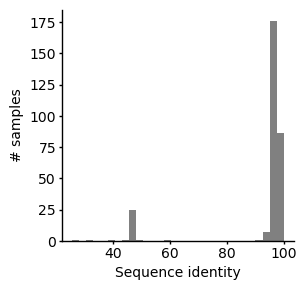

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams["svg.fonttype"] =  'none'
plt.rcParams["figure.figsize"] = (3,3)

plt.hist(df[2].values, bins=30, color='grey')
clean_plt(plt.gca())
plt.xlabel('Sequence identity')
plt.ylabel('# samples')
plt.savefig('figures/hist_seq_id.svg')

# Do the same for foldseek

In [22]:
reference_database = '/disk4/share/software/foldseek/structures/pdb/pdb'
foldseek_df = protein_ded_df << (FoldSeek(id_col, seq_col, reference_database, query_type='seqs',  tmp_dir='/disk1/ariane/vscode/cec_degrader/manuscript/tmp/') >> Save(f'output/DEDBase_FoldSeek.pkl'))


--------------------------------------------------------------------------------
            Running command	foldseek databases ProstT5 weights tmp	             
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                                    Output:	                                    
--------------------------------------------------------------------------------
databases ProstT5 weights tmp 

MMseqs Version:              	10.941cd33
Tsv                          	false
Force restart with latest tmp	false
Remove temporary files       	false
Compressed                   	0
Threads                      	384
Verbosity                    	3


07/15 18:01:36 [NOTICE] Downloading 1 item(s)

07/15 18:01:36 [NOTICE] CUID#7 - Redirecting to https://steineggerlab.s3.amazonaws.com/foldseek/prostt5-f16-gguf.tar.gz

07/15 18:01:36 [NOTICE] CUID#10 - Redirecting to https://steinegg

In [29]:
foldseek_df = foldseek_df.sort_values(by='fident', ascending=False)
foldseek_df = foldseek_df.drop_duplicates(subset='query')
len(foldseek_df[foldseek_df['fident'] < 0.5])

1

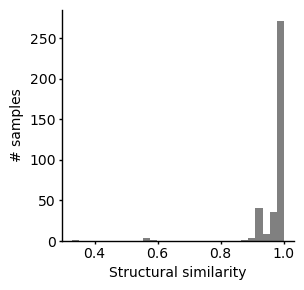

In [8]:

foldseek_df = pd.read_pickle(f'output/DEDBase_FoldSeek.pkl')

foldseek_df = foldseek_df.sort_values(by='fident', ascending=False)
foldseek_df = foldseek_df.drop_duplicates(subset='query')
len(foldseek_df[foldseek_df['fident'] < 0.5])
plt.rcParams["figure.figsize"] = (3,3)

plt.hist(foldseek_df['fident'].values, bins=30, color='grey')
clean_plt(plt.gca())
plt.xlabel('Structural similarity')
plt.ylabel('# samples')
plt.savefig('figures/hist_structure_id.svg')

In [32]:
foldseek_df

,query,target,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits
104949,DEDB825,1bvy-assembly1.cif.gz_F,1.000,152,0,0,480,631,1,152,1.761000e-18,949
142667,DEDB832,1bvy-assembly1.cif.gz_F,1.000,152,0,0,480,631,1,152,2.173000e-18,948
207996,DEDB1167,1bvy-assembly1.cif.gz_F,1.000,152,0,0,480,631,1,152,1.708000e-18,948
190679,DEDB778,1bvy-assembly1.cif.gz_F,1.000,152,0,0,480,631,1,152,2.549000e-18,948
85902,DEDB844,1bvy-assembly1.cif.gz_F,1.000,152,0,0,480,631,1,152,1.726000e-18,948
...,...,...,...,...,...,...,...,...,...,...,...,...
120102,DEDB1242,7ute-assembly1.cif.gz_A,0.569,190,81,0,3,191,1,190,1.839000e-13,706
33937,DEDB1240,7ute-assembly1.cif.gz_A,0.569,190,81,0,3,191,1,190,2.045000e-13,714
173692,DEDB1241,7ute-assembly1.cif.gz_A,0.564,190,82,0,3,191,1,190,1.639000e-13,699
203354,DEDB1243,7ute-assembly1.cif.gz_A,0.559,190,83,0,3,191,1,190,1.019000e-13,711
